# Unit12｜狀態切換與分段：GMM /（概念）HMM + Change Point

對應講義：`Part_3/Unit12_Dynamic_Regimes_HMM_ChangePoint.md`

本 Notebook 示範：
- GMM 產生每點的狀態機率
- Viterbi 平滑（轉移成本）
- state timeline 與切換點


In [50]:
# ===== Shared environment (repo-root + outputs/) =====
import os, sys
from pathlib import Path

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)

def find_repo_root(start=None):
    start = Path(start or os.getcwd()).resolve()
    for p in [start] + list(start.parents):
        if (p / 'Jupyter_Scripts').is_dir():
            return p
    if IN_COLAB:
        candidate = Path('/content/drive/MyDrive/ChemEng_AI_Course_Materials')
        if (candidate / 'Jupyter_Scripts').is_dir():
            return candidate
    return start

REPO_ROOT = find_repo_root()
OUTPUT_DIR = Path(__file__).parent if '__file__' in globals() else Path.cwd()
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
os.chdir(OUTPUT_DIR)
os.makedirs('Unit12_Results', exist_ok=True)
print('REPO_ROOT:', REPO_ROOT)
print('Working dir:', os.getcwd())


REPO_ROOT: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials
Working dir: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_3


In [51]:
# 匯入套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.unicode_minus'] = False

RNG = np.random.default_rng(42)
print('Imports OK')

Imports OK


## 1. 生成具有 4 階段的批次資料（示範）

In [52]:
N = 2000
t = np.arange(N)

phase = np.zeros(N, dtype=int)
phase[400:1200] = 1
phase[1200:1600] = 2
phase[1600:] = 3

T = np.zeros(N)
P = np.zeros(N)
C = np.zeros(N)

for i in range(N):
    if phase[i] == 0:
        T[i] = 60 + 0.25*i + RNG.normal(0, 0.8)
        P[i] = 3 + 0.002*i + RNG.normal(0, 0.05)
        C[i] = 0.02*i + RNG.normal(0, 0.5)
    elif phase[i] == 1:
        T[i] = 160 + 2*np.sin(i/40) + RNG.normal(0, 0.6)
        P[i] = 6.5 + 0.2*np.sin(i/50) + RNG.normal(0, 0.05)
        C[i] = 60 + 10*np.sin(i/60) + RNG.normal(0, 1.0)
    elif phase[i] == 2:
        T[i] = 155 + RNG.normal(0, 0.5)
        P[i] = 6.2 + RNG.normal(0, 0.05)
        C[i] = 55 + RNG.normal(0, 0.9)
    else:
        T[i] = 155 - 0.12*(i-1600) + RNG.normal(0, 0.7)
        P[i] = 6.2 - 0.002*(i-1600) + RNG.normal(0, 0.05)
        C[i] = 55 - 0.05*(i-1600) + RNG.normal(0, 0.8)

df = pd.DataFrame({'t': t, 'T': T, 'P': P, 'C': C, 'true_phase': phase})
display(df.head())


,t,T,P,C,true_phase
0,0,60.243774,2.948001,0.375226,0
1,1,61.002452,2.904448,-0.631090,0
2,2,60.602272,2.988188,0.031599,0
3,3,60.067565,3.049970,0.448896,0
4,4,61.052825,3.064362,0.313755,0


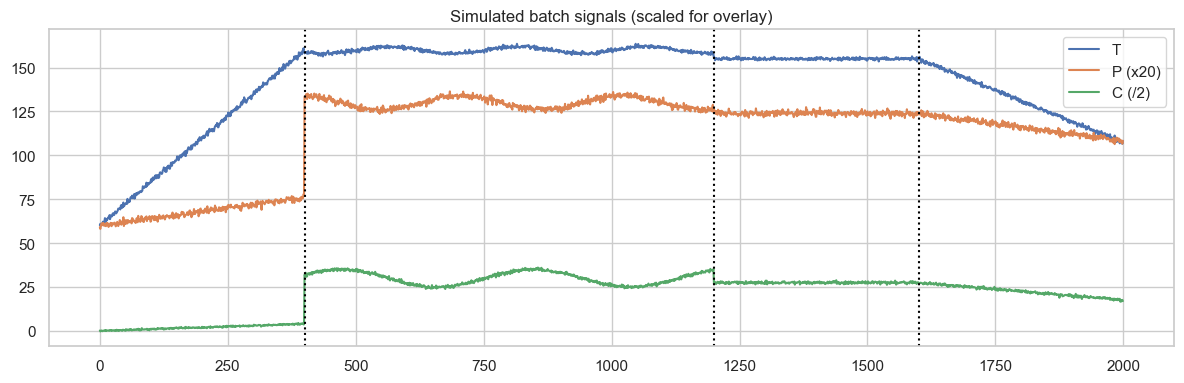

Saved: Unit12_Results/01_signals.png


In [53]:
plt.figure(figsize=(12, 4))
plt.plot(df['t'], df['T'], label='T')
plt.plot(df['t'], df['P']*20, label='P (x20)')
plt.plot(df['t'], df['C']/2, label='C (/2)')
for cp in [400, 1200, 1600]:
    plt.axvline(cp, color='black', linestyle=':')
plt.legend()
plt.title('Simulated batch signals (scaled for overlay)')
plt.tight_layout()
plt.savefig('./Unit12_Results/01_signals.png', dpi=150)
plt.show()
print('Saved: Unit12_Results/01_signals.png')


## 2. GMM：軟分群（每點狀態機率）

In [54]:
X = df[['T','P','C']].values
sc = StandardScaler()
Xz = sc.fit_transform(X)

K = 4
gmm = GaussianMixture(n_components=K, covariance_type='full', random_state=42)
gmm.fit(Xz)

proba = gmm.predict_proba(Xz)
state_raw = proba.argmax(axis=1)

df['state_raw'] = state_raw
print('proba shape:', proba.shape)


proba shape: (2000, 4)


c:\Users\Yao-ChenChuang\miniconda3\envs\THAICHE_PY39\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


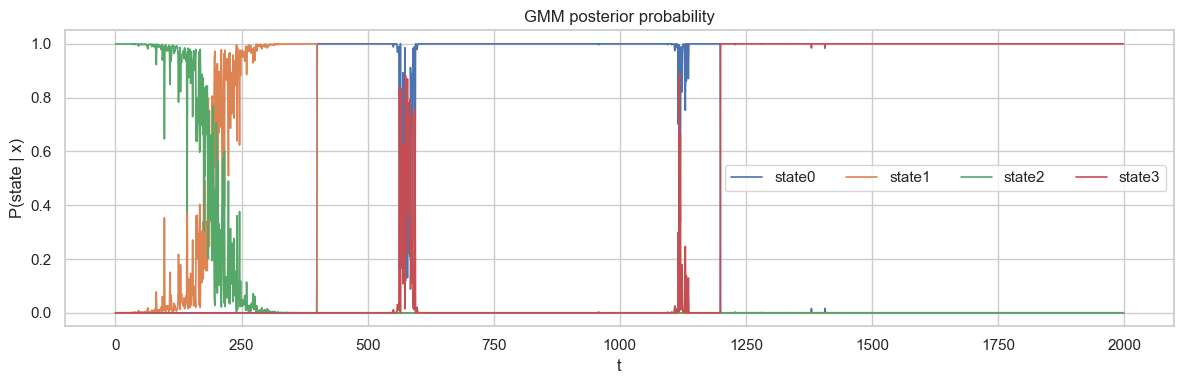

Saved: Unit12_Results/02_state_proba.png


In [55]:
plt.figure(figsize=(12, 4))
for k in range(proba.shape[1]):
    plt.plot(df['t'], proba[:, k], linewidth=1.2, label=f'state{k}')
plt.title('GMM posterior probability')
plt.xlabel('t')
plt.ylabel('P(state | x)')
plt.legend(ncol=4)
plt.tight_layout()
plt.savefig('./Unit12_Results/02_state_proba.png', dpi=150)
plt.show()
print('Saved: Unit12_Results/02_state_proba.png')


## 3. Viterbi 平滑：加入轉移成本

In [56]:
K = proba.shape[1]
stay = 0.995
trans = np.full((K, K), (1 - stay) / (K - 1))
np.fill_diagonal(trans, stay)

log_trans = np.log(trans + 1e-12)
log_emit = np.log(proba + 1e-12)

Tlen = log_emit.shape[0]
dp = np.zeros((Tlen, K))
ptr = np.zeros((Tlen, K), dtype=int)

dp[0] = log_emit[0]
for i in range(1, Tlen):
    for k in range(K):
        scores = dp[i-1] + log_trans[:, k]
        ptr[i, k] = int(np.argmax(scores))
        dp[i, k] = scores[ptr[i, k]] + log_emit[i, k]

state_vit = np.zeros(Tlen, dtype=int)
state_vit[-1] = int(np.argmax(dp[-1]))
for i in range(Tlen - 2, -1, -1):
    state_vit[i] = ptr[i+1, state_vit[i+1]]

df['state_viterbi'] = state_vit
print('Viterbi done')


Viterbi done


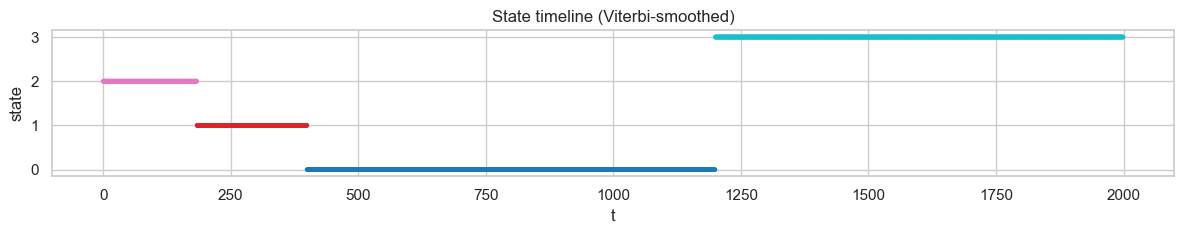

Saved: Unit12_Results/03_state_timeline.png


In [57]:
plt.figure(figsize=(12, 2.5))
plt.scatter(df['t'], df['state_viterbi'], s=6, c=df['state_viterbi'], cmap='tab10')
plt.yticks(range(K))
plt.xlabel('t')
plt.ylabel('state')
plt.title('State timeline (Viterbi-smoothed)')
plt.tight_layout()
plt.savefig('./Unit12_Results/03_state_timeline.png', dpi=150)
plt.show()
print('Saved: Unit12_Results/03_state_timeline.png')


In [58]:
cp = (np.where(np.diff(df['state_viterbi'].values) != 0)[0] + 1).tolist()
print('change points:', cp)

import json
Path('./Unit12_Results/change_points.json').write_text(json.dumps({'change_points': cp}, indent=2), encoding='utf-8')
print('Saved: Unit12_Results/change_points.json')


change points: [184, 400, 1200]
Saved: Unit12_Results/change_points.json


In [59]:
profile = df.groupby('state_viterbi')[['T','P','C']].agg(['mean','std'])
profile.to_csv('./Unit12_Results/state_profile_table.csv')
print('Saved: Unit12_Results/state_profile_table.csv')
display(profile)


Saved: Unit12_Results/state_profile_table.csv


T                    P                    C          
                     mean        std      mean       std       mean       std
state_viterbi                                                                
0              159.896106   1.521558  6.493157  0.151635  60.357104  7.171259
1              132.891346  15.695233  3.583054  0.131838   5.775920  1.402369
2               82.869191  13.318475  3.178448  0.113987   1.857499  1.213038
3              143.064553  15.457181  5.999345  0.260599  49.992671  6.465803

## 4. 工業驗收：最小停留時間、切換次數、與 SOP 可用性

這段把 state 序列變成『現場可用』：
- 過短片段要合併（minimum dwell time）
- 切換次數要有限（switching rate）
- 你要能把 state 命名成工程語言


In [60]:
# 4.1 計算每段狀態的持續時間（run-length encoding）

def runs(states):
    states = np.asarray(states, dtype=int)
    starts = [0]
    vals = [states[0]]
    lens = []
    for i in range(1, len(states)):
        if states[i] != states[i-1]:
            lens.append(i - starts[-1])
            starts.append(i)
            vals.append(states[i])
    lens.append(len(states) - starts[-1])
    return pd.DataFrame({'start': starts, 'state': vals, 'length': lens})

seg = runs(df['state_viterbi'].values)
seg['end'] = seg['start'] + seg['length'] - 1

print('n_segments:', len(seg))
display(seg.head(10))


n_segments: 4


,start,state,length,end
0,0,2,184,183
1,184,1,216,399
2,400,0,800,1199
3,1200,3,800,1999


n_segments before: 4
n_segments after : 4
min segment length after: 184


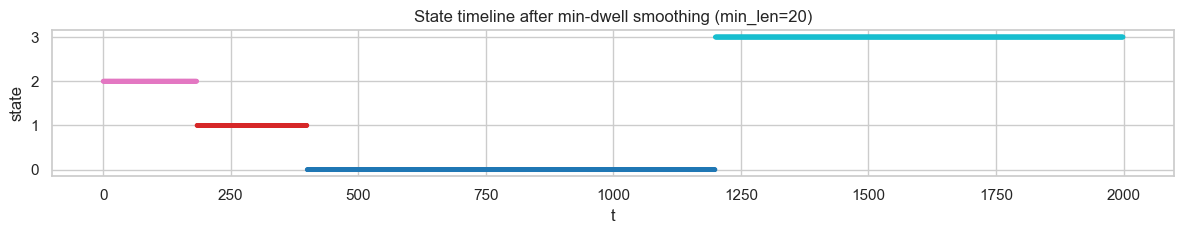

Saved: Unit12_Results/04_state_timeline_min_dwell.png


In [61]:
# 4.2 Minimum dwell time：把太短片段合併（示範）

min_len = 20  # 你可以改成 5/10/30，視取樣頻率
state_sm = df['state_viterbi'].values.copy()

seg2 = runs(state_sm)

# 迭代合併短片段：併到前一段（簡化示範；也可併到機率次高）
changed = True
while changed:
    changed = False
    seg2 = runs(state_sm)
    for _, r in seg2.iterrows():
        if r['length'] < min_len:
            s = int(r['start']); e = int(r['start'] + r['length'])
            # 併回前一段（如果沒有前一段就併到下一段）
            if s > 0:
                state_sm[s:e] = state_sm[s-1]
            elif e < len(state_sm):
                state_sm[s:e] = state_sm[e]
            changed = True
            break

seg_sm = runs(state_sm)
seg_sm['end'] = seg_sm['start'] + seg_sm['length'] - 1

print('n_segments before:', len(seg))
print('n_segments after :', len(seg_sm))
print('min segment length after:', int(seg_sm['length'].min()))

plt.figure(figsize=(12, 2.5))
plt.scatter(df['t'], state_sm, s=6, c=state_sm, cmap='tab10')
plt.yticks(range(int(state_sm.max())+1))
plt.xlabel('t')
plt.ylabel('state')
plt.title(f'State timeline after min-dwell smoothing (min_len={min_len})')
plt.tight_layout()
plt.savefig('./Unit12_Results/04_state_timeline_min_dwell.png', dpi=150)
plt.show()
print('Saved: Unit12_Results/04_state_timeline_min_dwell.png')


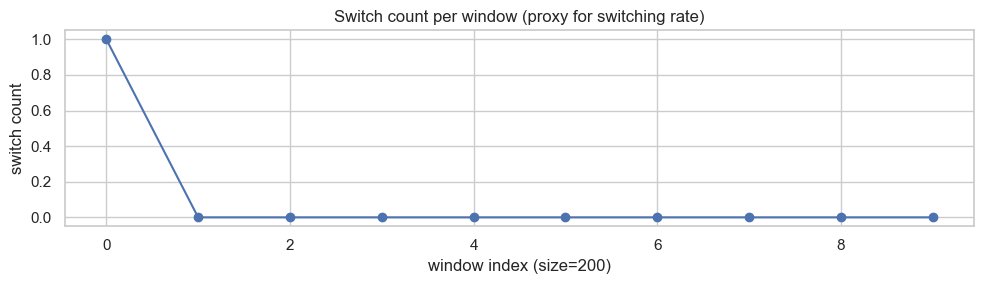

Saved: Unit12_Results/05_switch_rate.png


In [62]:
# 4.3 切換頻率：每 200 點切換幾次？（示範）

window = 200
switches = []
for start in range(0, len(state_sm), window):
    end = min(len(state_sm), start + window)
    sw = int(np.sum(np.diff(state_sm[start:end]) != 0))
    switches.append(sw)

plt.figure(figsize=(10, 3))
plt.plot(switches, marker='o')
plt.title('Switch count per window (proxy for switching rate)')
plt.xlabel(f'window index (size={window})')
plt.ylabel('switch count')
plt.tight_layout()
plt.savefig('./Unit12_Results/05_switch_rate.png', dpi=150)
plt.show()
print('Saved: Unit12_Results/05_switch_rate.png')


In [63]:
# 4.4 與 true_phase 對照（教學用）：看看你分段抓到多少結構

# 注意：state label 與 phase label 不一定對齊；這裡用最簡單的多對一映射做示範
from collections import defaultdict

mapping = {}
for st in np.unique(state_sm):
    # 找這個 state 最常出現的 true_phase
    ph = df.loc[state_sm == st, 'true_phase'].value_counts().idxmax()
    mapping[int(st)] = int(ph)

pred_phase = np.vectorize(lambda s: mapping[int(s)])(state_sm)
acc = float(np.mean(pred_phase == df['true_phase'].values))
print('State->Phase mapping:', mapping)
print('Approx phase accuracy (after mapping):', round(acc, 3))

# confusion-like table
ct = pd.crosstab(pd.Series(df['true_phase'], name='true_phase'), pd.Series(state_sm, name='state'))
display(ct)


State->Phase mapping: {0: 1, 1: 0, 2: 0, 3: 2}
Approx phase accuracy (after mapping): 0.8


state,0,1,2,3
true_phase,,,,
0,0,216,184,0
1,800,0,0,0
2,0,0,0,400
3,0,0,0,400


**工程解讀提示**：
- 若需要大量 min-dwell 合併才穩，代表資料太吵或特徵不足（先做資料品質/特徵工程）
- 若 switching rate 在某段突然暴增，常見原因是控制迴路振盪、感測器壞點、或流程進入過渡段
